In [26]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from scipy.optimize import minimize

class WeatherModel():
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'STP'])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.ffill()

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]]
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order):

        if self.residuals is None:
            self.get_residuals()

        arma_models = []

        pbar = tqdm(total=self.residuals.shape[1])

        for i in range(self.residuals.shape[1]):
            pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
            pbar.update(1)
            model = ARIMA(self.residuals[:, i], order=order)
            model_fit = model.fit()
            arma_models.append(model_fit)
            
        self.arma_models = arma_models

        return None
    
    def fit(self, order):
        self.fit_arma(order)
        return None
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



In [2]:
wm = WeatherModel('3968119.csv')


wm.fit(order=(1, 0, 1))


Fitting 8/8 ARMA models: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


In [3]:
predictions = wm.predict(start=0, future=365*10)

Seasonal Predictions (12045, 8)
Residual shape (8, 12046)
Num stacks 33
Num extras 1


(8, 12046)
(8, 8395)


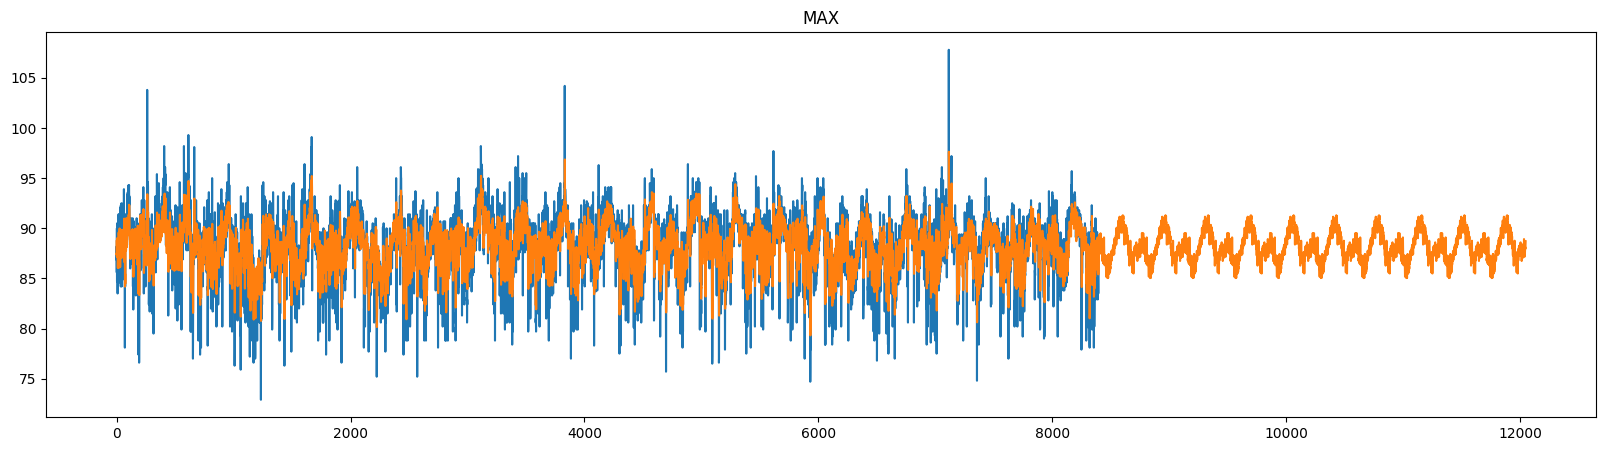

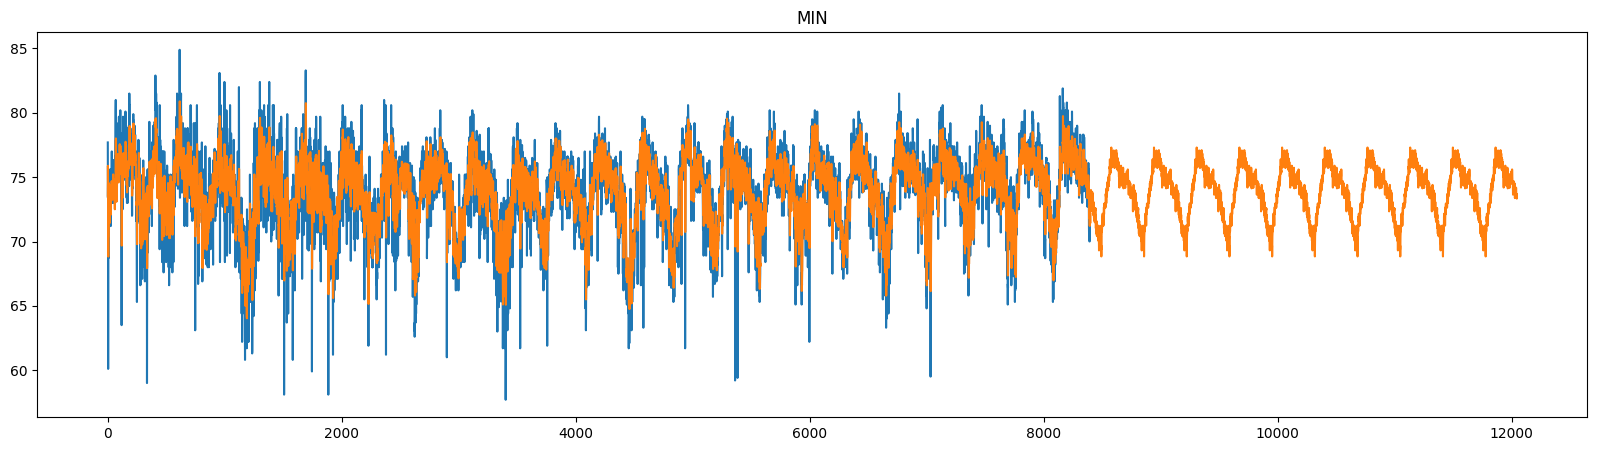

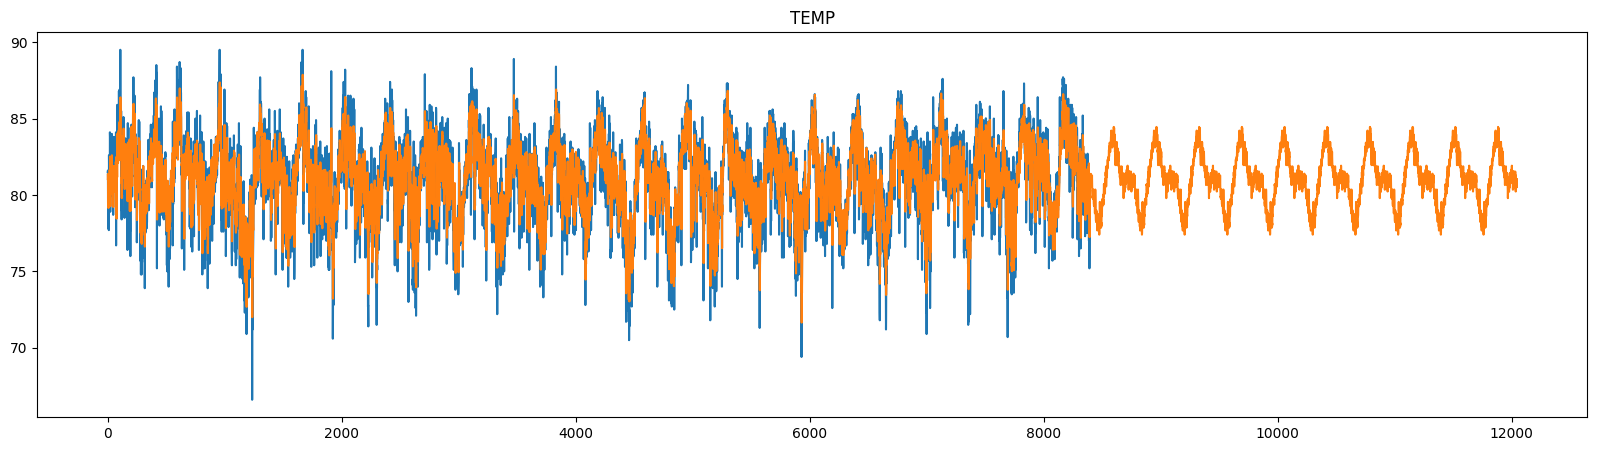

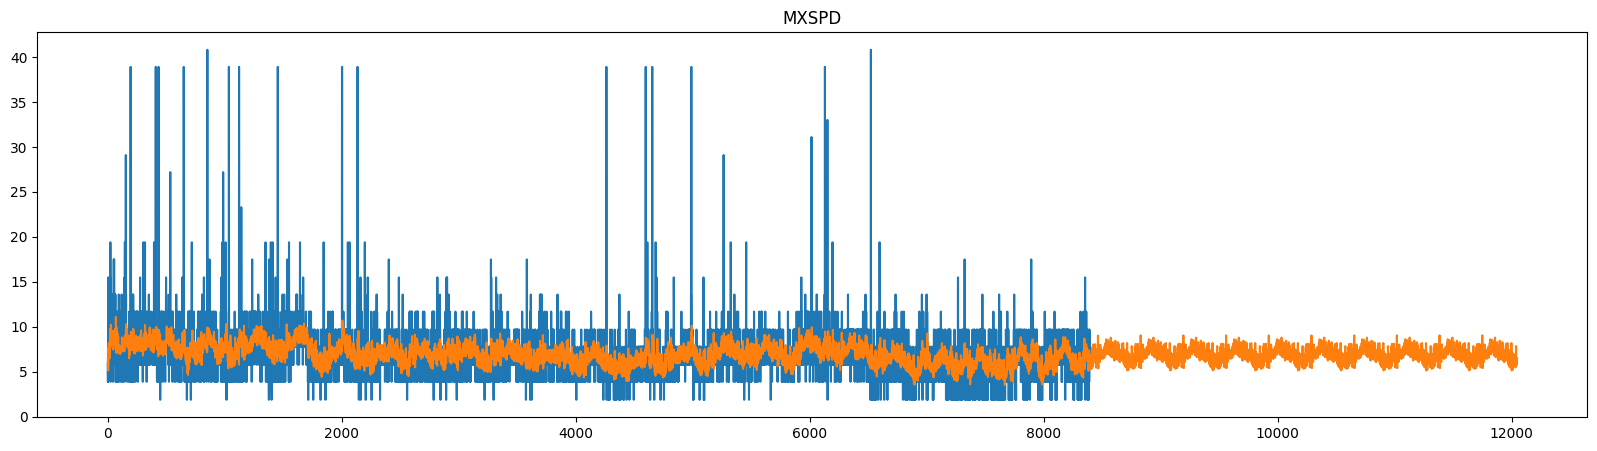

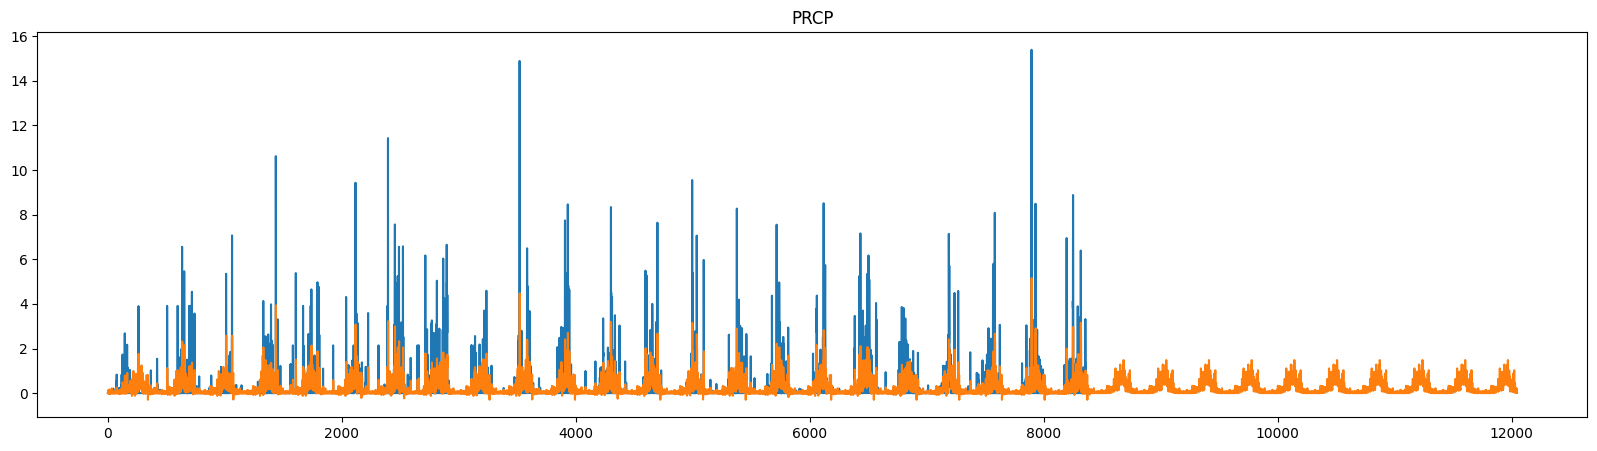

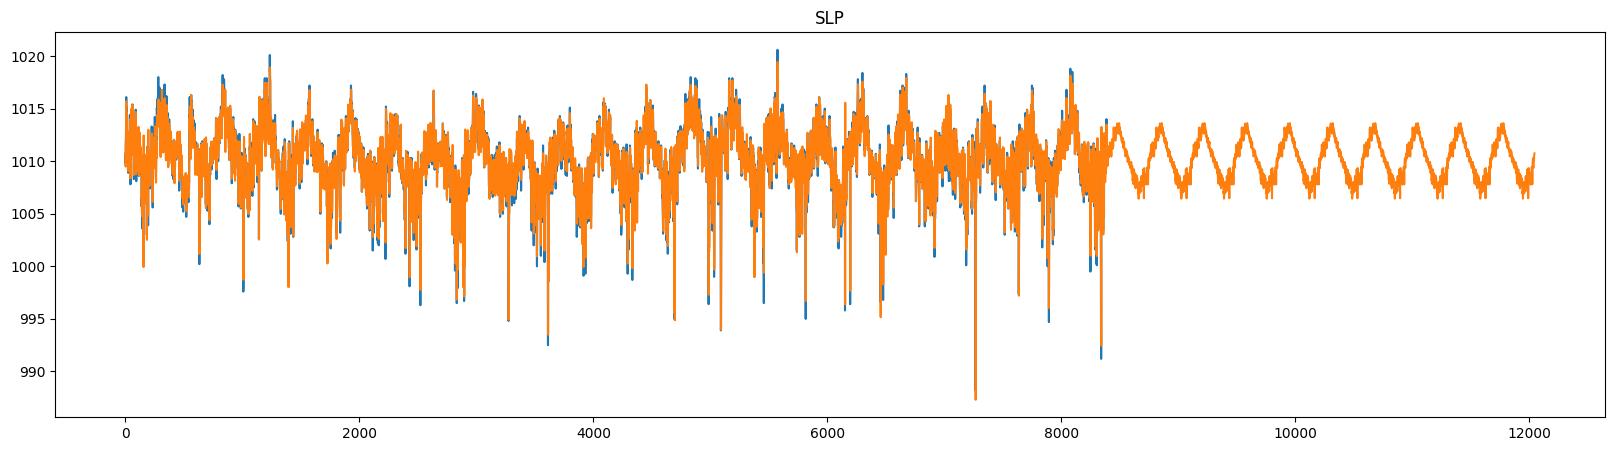

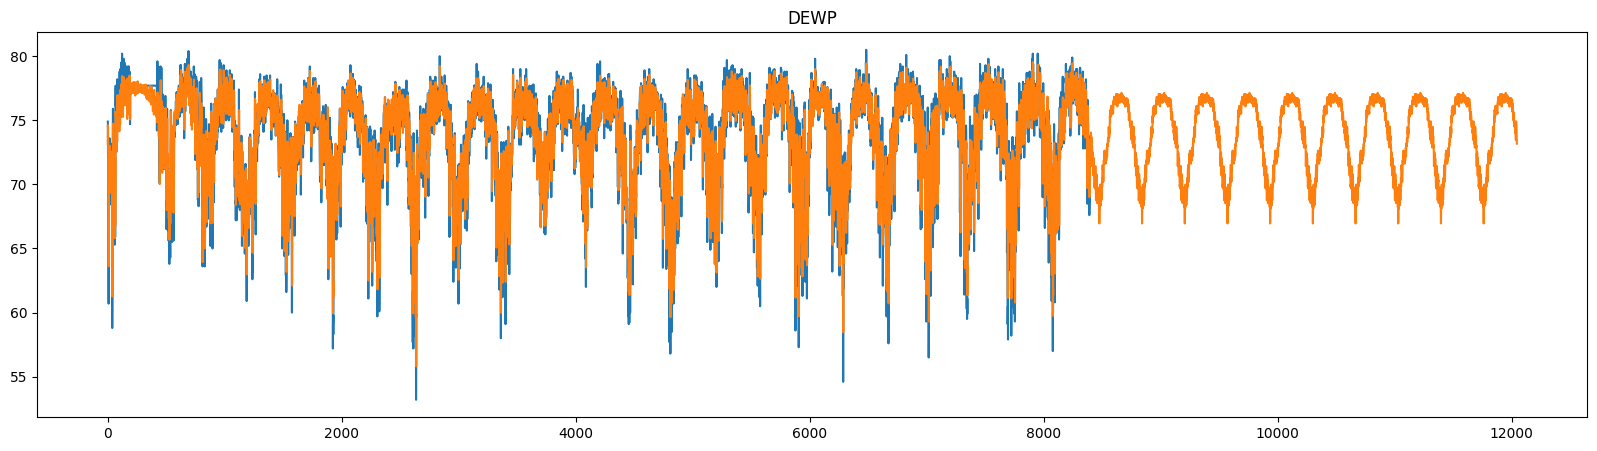

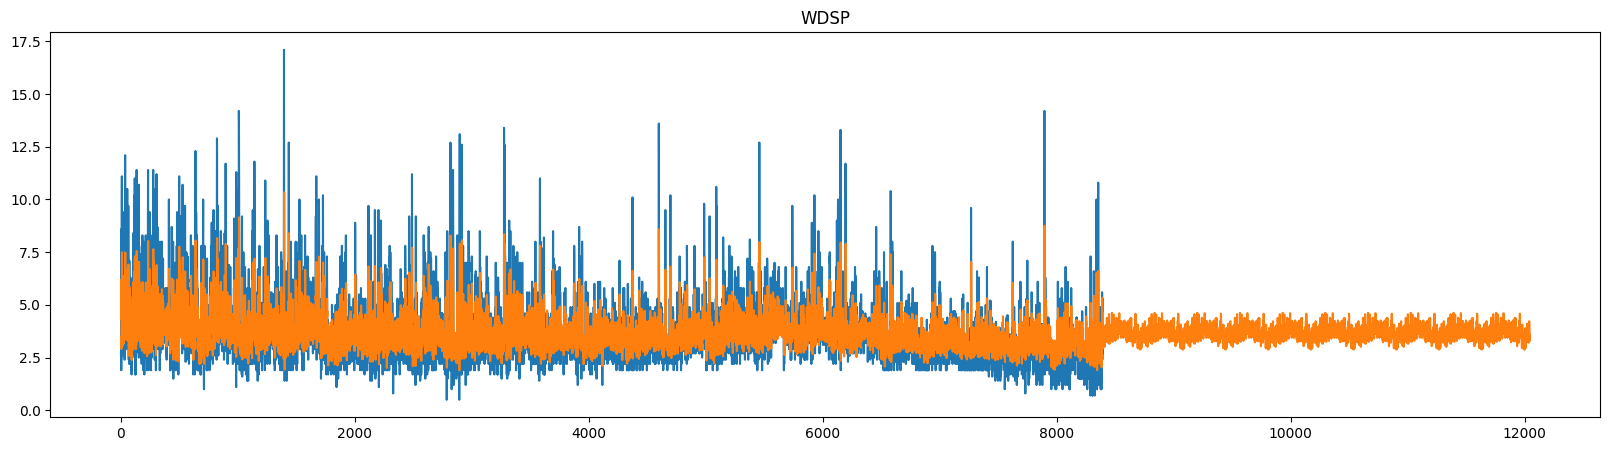

In [4]:
print(predictions.shape)

unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
print(unrolled_data.shape)
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


food (217, 4)
Weather (217, 14)


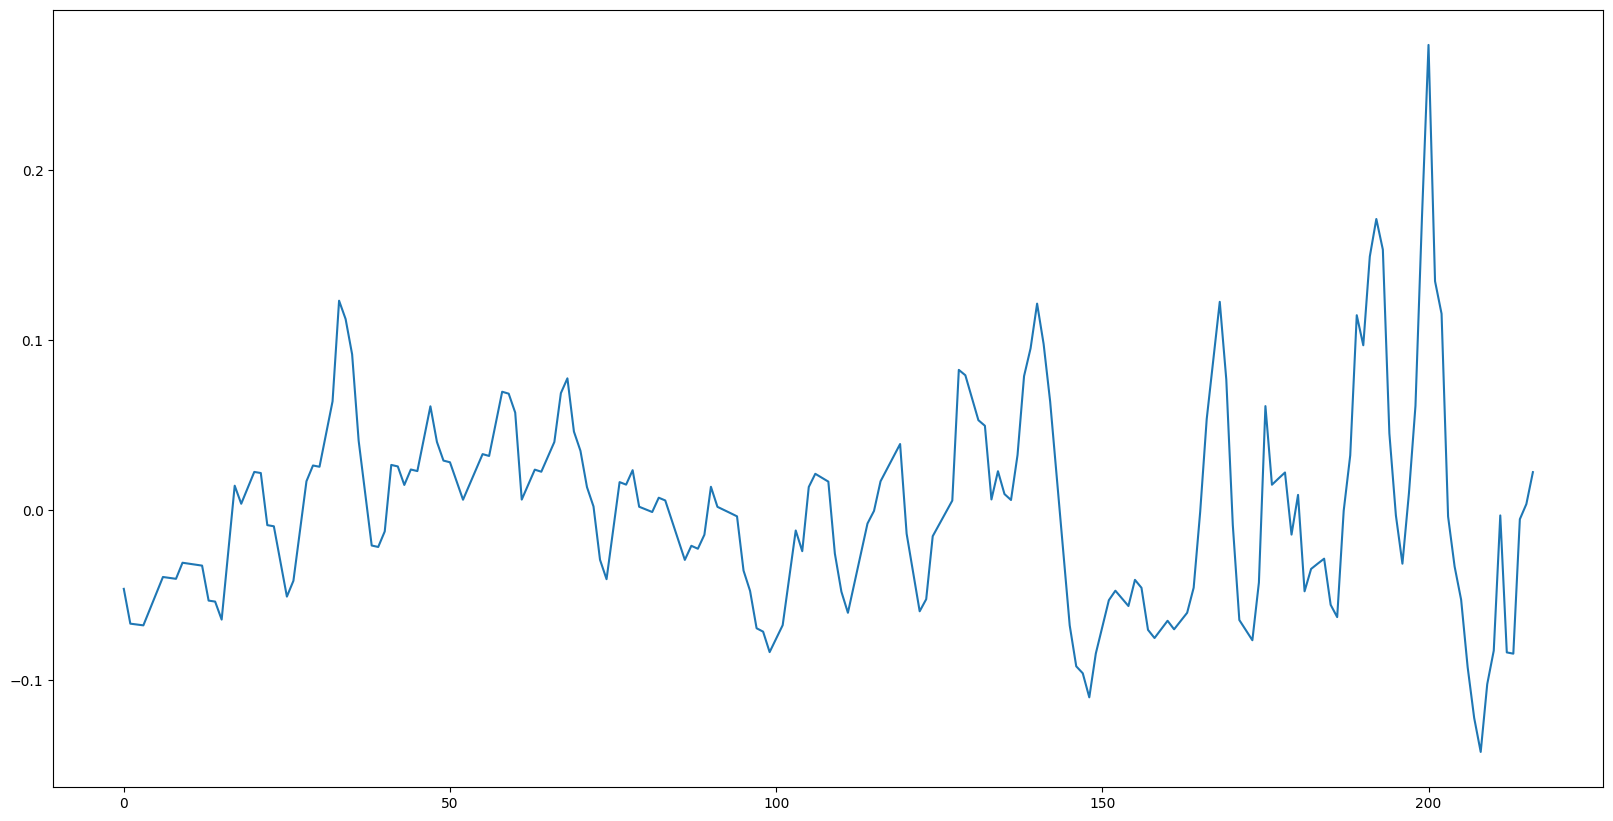

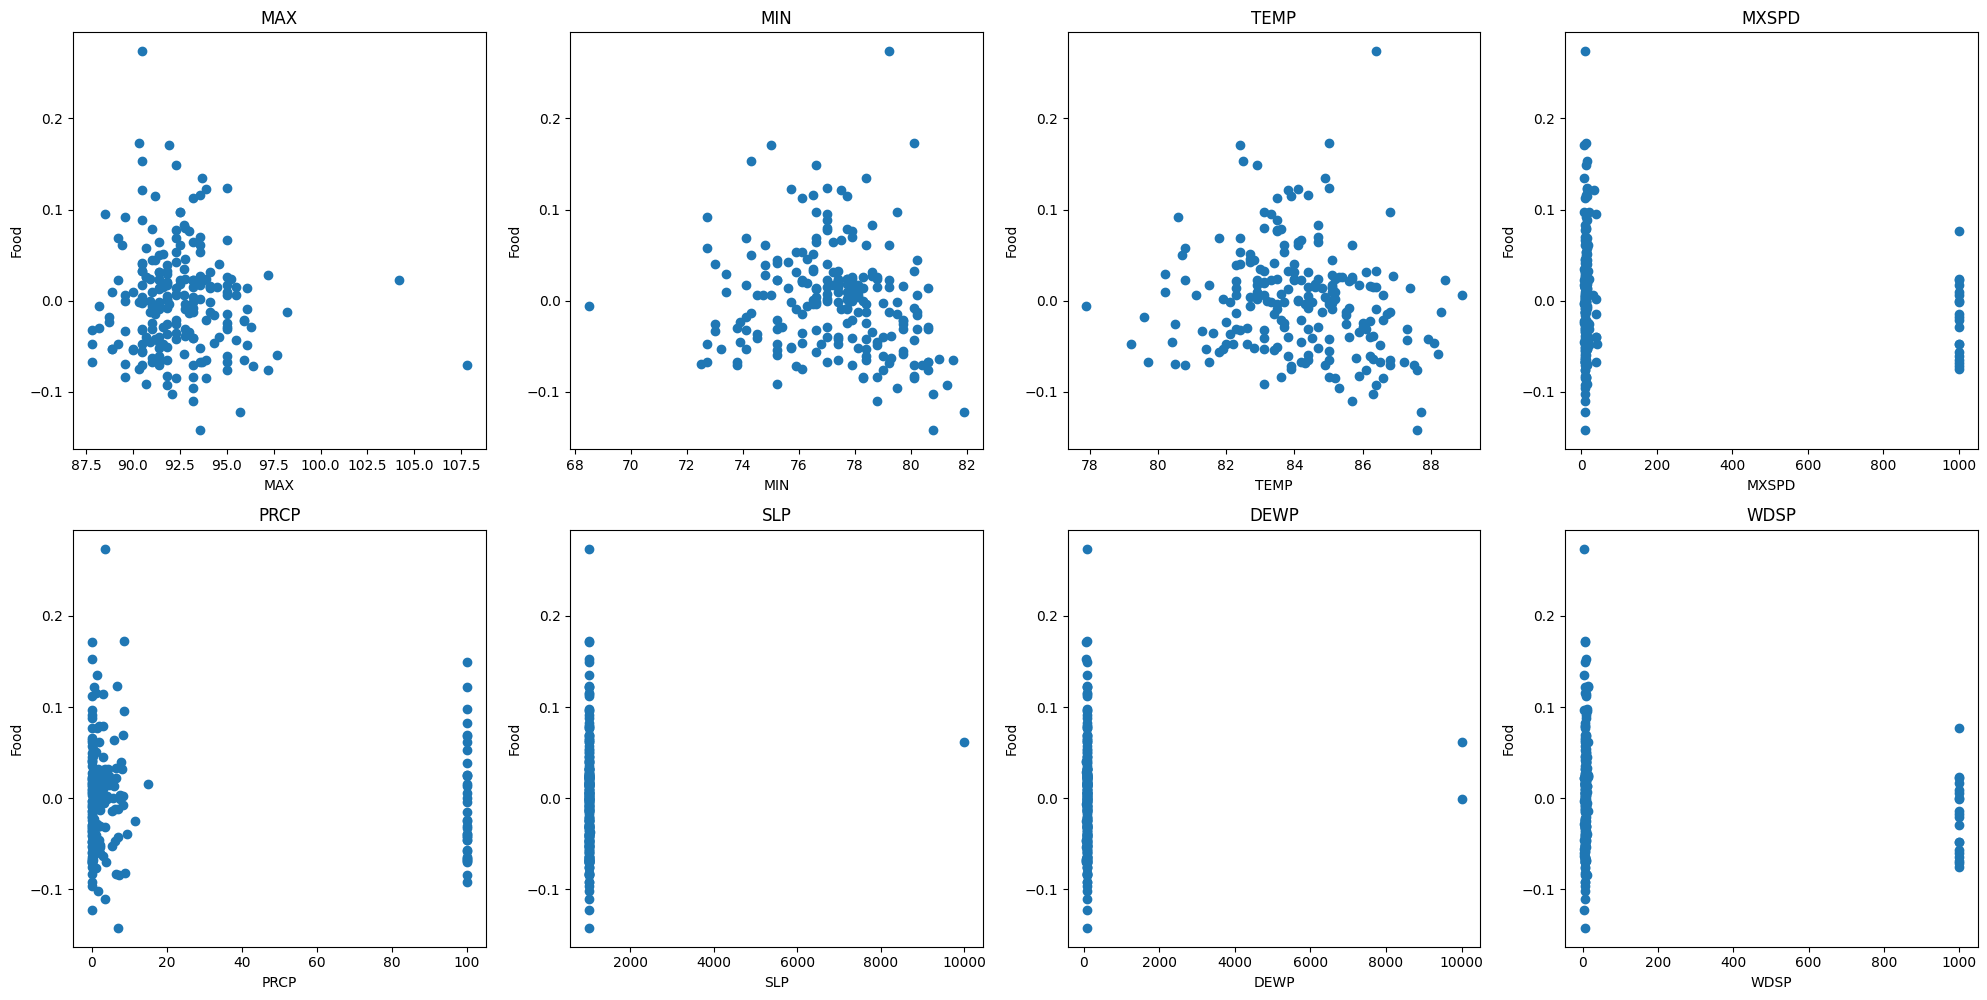

In [42]:
#Plotting the scatter of feature vs food prioce for triend
unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
weather = pd.read_csv('3968119.csv')
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather = weather.set_index("DATE")
weather = weather.loc["2007":]
weather = weather.resample('M').max()
food = pd.read_csv("Ilocos_Sur_cleaned.csv")
food['Date'] = pd.to_datetime(food['Date'])
food = food.set_index("Date")
food = food.loc[: "2025-01-01"]
print("food",food.shape)
print("Weather",weather.shape)
plt.figure(figsize=(20, 10.1))


def exponential(x, a, b, c):
    return  a*b**x + c

x = np.arange(len(food))
y = food["Close"].values

popt, _ = curve_fit(exponential, x, y, p0=[1, 1, 1])


plt.plot(x,food["Close"] - exponential(x, *popt))
plt.show()

plt.figure(figsize=(20, 10.1))
for i in range(len(predictions)):
    plt.subplot(2,4,i+1)
    plt.title(feature_names[i])
    plt.scatter(weather[feature_names[i]], food["Close"] - exponential(x, *popt))
    plt.ylabel("Food")
    plt.xlabel(feature_names[i])

plt.tight_layout()
plt.show()


In [ ]:
class Combined_model:
    def __init__(self, features, labels,constants):
        self.features = features
        self.labels = labels

    def equation(self,constants):
        return np.abs(constants[0]*death) + np.abs(constants[1]*hamster_on_a_stick) + np.abs(constants[2]*thingamajig) + np.abs(constants[3]* stuffamajiger) + np.abs(constants[4]*Colasdfiuh)
    
    def fit(self):
        x0 = np.ones(len(self.features))
        sol = minimize(self.equation, x0, )